In [3]:
from train_model import load_data

import matplotlib.pyplot as plt
import datetime as dt
import paths

from preprocessing import visualisation

In [4]:
import pandas as pd
import geopandas as gp
from shapely.geometry import Polygon, Point
from apollo import osgconv as osg
from apollo import hydropoint

In [5]:
# Function to round up based on the sign of the value
def round_to_nearest(value, max=True, base=0.25, buffer=5):
    if max:
        return np.ceil(value/base) * base + buffer*base 
    else: 
        return np.floor(value / base) * base - buffer*base

def extract_raster_to_interpolate(catchment_path, resolution, buffer=5):
  
    boundary = gp.read_file(catchment_path)
    minx, miny, maxx, maxy = boundary.total_bounds
    
    # Convert bounding box coordinates to latitude and longitude
    lat_min, lon_min = osg.BNG_2_latlon(minx, miny)
    lat_max, lon_max = osg.BNG_2_latlon(maxx, maxy)
    
    # Round the bounding box coordinates
    lat_min = round_to_nearest(lat_min, max=False, base=resolution, buffer=buffer)
    lon_min = round_to_nearest(lon_min, max=False, base=resolution, buffer=buffer)
    lat_max = round_to_nearest(lat_max, base=resolution, buffer=buffer)
    lon_max = round_to_nearest(lon_max, base=resolution, buffer=buffer)
        
    return lat_min, lat_max, lon_min, lon_max

In [6]:
def convenient_f(x1, x2, f):
    x = np.vstack((x1.ravel(), x2.ravel())).T
    z = f(x)
    return z.reshape(x1.shape)

def plot_interpolation(x1, x2, z, f):

    X1, X2 = np.meshgrid(x1, x2, indexing='ij') 
    x1_surface, x2_surface = np.meshgrid(np.linspace(x1.min(), x1.max(), len(x1)), np.linspace(x2.min(), x2.max(), len(x2)), indexing='ij')

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.plot(X1.ravel(), X2.ravel(), z.ravel(), "ok")
    ax.plot_surface(x1_surface, x2_surface, convenient_f(x1_surface, x2_surface, f), alpha=0.5)
    plt.show()

In [7]:
from scipy.interpolate import griddata

def fill_non_finite_values(data):
    # Convert the input to a numpy array if it isn't already
    data = np.array(data)
    
    # Check for non-finite values in the data
    if not np.all(np.isfinite(data)):
        data_filled = data.copy()
        
        # Get indices of finite and non-finite values
        finite_idx = np.isfinite(data_filled)
        non_finite_idx = ~finite_idx
        
        # Get coordinates of finite and non-finite values
        x_finite, y_finite = np.where(finite_idx)
        x_non_finite, y_non_finite = np.where(non_finite_idx)
        
        # Get finite values
        finite_values = data_filled[finite_idx]
        
        # Perform interpolation
        interpolated_values = griddata(
            (x_finite, y_finite),
            finite_values,
            (x_non_finite, y_non_finite),
            method='linear'
        )
        
        # For any remaining NaNs after interpolation, use nearest neighbor
        remaining_nans = np.isnan(interpolated_values)
        if np.any(remaining_nans):
            interpolated_values[remaining_nans] = griddata(
                (x_finite, y_finite),
                finite_values,
                (x_non_finite[remaining_nans], y_non_finite[remaining_nans]),
                method='nearest'
            )
        
        # Fill non-finite values with interpolated values
        data_filled[non_finite_idx] = interpolated_values

        return data_filled
    else:
        return data

In [8]:
import scipy

# Function to interpolate for each timestep
def interpolate_surface(subset, factor=1000*24, var_name='tp'):
    lats = subset.latitude.values
    lons = subset.longitude.values
    times = subset.time.values

    interpolated_functions = {}

    for i, time in enumerate(times):
        print(time)
        # Extract data for the current timestep
        data = subset[var_name].sel(time=time)
        
        # Check for non-finite values in the data
        data_filled = fill_non_finite_values(data)

        # Interpolate using LinearNDInterpolator
        try:
            interpolator = scipy.interpolate.RegularGridInterpolator((lats, lons), data_filled*factor, method='cubic')
        except:
            interpolator = scipy.interpolate.RegularGridInterpolator((lats, lons), data_filled*factor, method='linear')
        # Store the interpolator function
        interpolated_functions[time] = interpolator
        
        if i < 20:
            plot_interpolation(lats, lons, data.values, interpolator)

    return interpolated_functions

In [9]:
def integrate_rainfall_over_polygon(polygon, interp_func, resolution=0.05):
    
    # Create a grid of points within the bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds
    x = np.arange(minx, maxx, resolution)
    y = np.arange(miny, maxy, resolution)
    grid_x, grid_y = np.meshgrid(x, y)
    
    # Flatten the grid for evaluation
    points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
    
    # Check which points are within the polygon
    mask = np.array([polygon.contains(Point(p)) for p in points])
    inside_points = points[mask]
    
    # Evaluate the interpolated function at the inside points
    rainfall_values = interp_func(inside_points)
    
    # Sum the rainfall values and multiply by the area of each grid cell
    total_rainfall = np.sum(rainfall_values) / len(inside_points)
    
    return total_rainfall

In [10]:
def convert_polygon(polygon, conversion_func):
    new_coords = [conversion_func(*coord) for coord in polygon.exterior.coords]
    return Polygon(new_coords)

In [14]:
db

,Station number,River,Location,Flow File,Boundary File,Area,Minimum altitude,10 percentile,50 percentile,90 percentile,...,High permeability bedrock,Moderate permeability bedrock,Very low permeability bedrock,Mixed permeability bedrock,FARL,CF-Natural,CF-Storage,CF-Regulated,CF-Effluent,CF-Abstraction
0,33035,Ely Ouse,Denver Complex,33035_gdf.csv,33035.shp,3430.0,-1.3,6.10,34.40,84.9,...,-,-,-,-,-,-,-,-,-,-
1,39016,Kennet,Theale,39016_gdf.csv,39016.shp,1033.4,44.6,91.30,153.50,205.2,...,-,-,-,-,-,-,-,-,-,-
2,5004,Glass,Fasnakyle,5004_gdf.csv,5004.shp,277.5,77.3,245.80,451.70,795.6,...,-,-,-,-,-,-,-,-,-,-
3,18002,Devon,Glenochil,18002_gdf.csv,18002.shp,181.0,4.4,42.90,293.00,528.3,...,-,-,-,-,-,-,-,-,-,-
4,72016,Wyre,Scorton Weir,72016_gdf.csv,72016.shp,88.8,30.8,97.90,213.45,440.0,...,-,-,-,-,-,-,-,-,-,-
5,95002,Broom,Inverbroom,95002_gdf.csv,95002.shp,141.4,4.8,239.70,395.00,663.6,...,-,-,-,-,-,-,-,-,-,-
6,5003,Glass,Kerrow Wood,5003_gdf.csv,5003.shp,481.8,52.8,242.40,478.70,811.2,...,-,-,-,-,-,-,-,-,-,-
7,54008,Teme,Tenbury,54008_gdf.csv,54008.shp,1134.4,48.4,110.00,214.40,383.7,...,-,-,-,-,-,-,-,-,-,-
8,39008,Thames,Eynsham,39008_gdf.csv,39008.shp,1616.2,60.0,76.00,118.40,222.7,...,-,-,-,-,-,-,-,-,-,-
9,8002,Spey,Kinrara,8002_gdf.csv,8002.shp,1011.7,210.0,284.80,516.00,812.1,...,-,-,-,-,-,-,-,-,-,-


In [23]:
import numpy as np

### Produce lumped regression files per catchment
RESOLUTION = 0.10
BUFFER = 3

db = pd.read_csv(paths.DATA + '/Catchments_Database.csv')
for i in [24]: #range(len(db)):
    db_path = paths.CATCHMENT_BASINS + '/' + str(db.loc[i][0])
    boundary_path = db_path + '/' + db.loc[i][4]
    
# Function to round up based on the sign of the value
def round_to_nearest(value, max=True, base=RESOLUTION, buffer=2):
    if max:
        return np.ceil(value/base) * base + buffer*RESOLUTION 
    else: 
        return np.floor(value / base) * base - buffer*RESOLUTION

def extract_raster_to_interpolate(catchment_path, resolution):
  
    boundary = gpd.read_file(catchment_path)
    minx, miny, maxx, maxy = boundary.total_bounds
    
    # Convert bounding box coordinates to latitude and longitude
    lat_min, lon_min = osg.BNG_2_latlon(minx, miny)
    lat_max, lon_max = osg.BNG_2_latlon(maxx, maxy)
    
    # Round the bounding box coordinates
    lat_min = round_to_nearest(lat_min, max=False, base=resolution)
    lon_min = round_to_nearest(lon_min, max=False, base=resolution)
    lat_max = round_to_nearest(lat_max, base=resolution)
    lon_max = round_to_nearest(lon_max, base=resolution)
        
    return lat_min, lat_max, lon_min, lon_max

lat_min, lat_max, lon_min, lon_max = extract_raster_to_interpolate(boundary_path, RESOLUTION)

# Create the corners of the bounding box in latitude and longitude
bbox_corners = [
    (lat_min, lon_min),  # Lower-left
    (lat_max, lon_min),  # Lower-right
    (lat_max, lon_max),  # Upper-right
    (lat_min, lon_max)   # Upper-left
    ]

print("Bounding Box Corners Latitude and Longitude:")
for i, (lat, lon) in enumerate(bbox_corners):
    print(f"Corner {i + 1}: ({lat}, {lon})")

Bounding Box Corners Latitude and Longitude:
Corner 1: (51.6, -1.5)
Corner 2: (52.50000000000001, -1.5)
Corner 3: (52.50000000000001, -0.10000000000000003)
Corner 4: (51.6, -0.10000000000000003)


C:\Users\aline\AppData\Local\Temp\ipykernel_23208\3489197680.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  db_path = paths.CATCHMENT_BASINS + '/' + str(db.loc[i][0])
C:\Users\aline\AppData\Local\Temp\ipykernel_23208\3489197680.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  boundary_path = db_path + '/' + db.loc[i][4]


In [24]:
# HIGH RESOLUTION DATA
station_nr = 33039
data_sep = xr.open_dataset(paths.WEATHER_UK + '/Rainfall_0.1/rainfall_aggregated_9to9_1981_0.1.nc')
data_sep = data_sep.sel(latitude=slice(57.1, 57.05), longitude=slice(-4.5, -4.45))
df_0_1 = data_sep.to_dataframe().reset_index()
df_0_1 = df_0_1.sort_values(by='time')
df_0_1['tp'] = df_0_1['tp']*100*24
df_0_1 = df_0_1.rename(columns={'time':'Date', 'tp':'Rain_0.1'})

# LOWER RESOLUTION DATA
data_low_res = xr.open_dataset(paths.WEATHER_UK + '/Rainfall/Rainfall_1981_aggregated_9to9.nc')
data_low_res = data_low_res.sel(latitude=slice(57.1, 57.0), longitude=slice(-4.5, -4.4))
df_0_25 = data_low_res.to_dataframe().reset_index()
df_0_25['tp'] = df_0_25['tp']*1000*24
df_0_25 = df_0_25.rename(columns={'time':'Date', 'tp':'Rain_0.25'})

rf_9to9_nrfa = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_nrfa.csv'), verbose=False)
rf_9to9_nrfa['Date'] = pd.to_datetime(rf_9to9_nrfa['Date'])

In [25]:
combined_df = rf_9to9_nrfa[['Date', 'Rain']].merge(df_0_1[['Date', 'Rain_0.1']], on='Date')
combined_df = combined_df.merge(df_0_25[['Date', 'Rain_0.25']], on='Date')
combined_df['Error_0.1'] = combined_df['Rain'] - combined_df['Rain_0.1']
combined_df['Error_0.25'] = combined_df['Rain'] - combined_df['Rain_0.25']
combined_df

,Date,Rain,Rain_0.1,Rain_0.25,Error_0.1,Error_0.25
0,1981-01-01,0.0,8.650184,18.674548,-8.650184,-18.674548
1,1981-01-02,0.1,34.671601,22.020852,-34.571601,-21.920852
2,1981-01-03,0.1,8.371694,4.959042,-8.271694,-4.859042
3,1981-01-04,0.0,4.528259,1.117485,-4.528259,-1.117485
4,1981-01-05,0.5,6.192158,7.212100,-5.692158,-6.712100
...,...,...,...,...,...,...
315,1981-12-27,3.7,2.633544,1.761060,1.066456,1.938940
316,1981-12-28,5.4,0.183334,0.040517,5.216666,5.359483
317,1981-12-29,7.0,0.663182,0.961203,6.336818,6.038797
318,1981-12-30,0.1,2.510029,2.726605,-2.410029,-2.626605


NameError: name 'mdt' is not defined

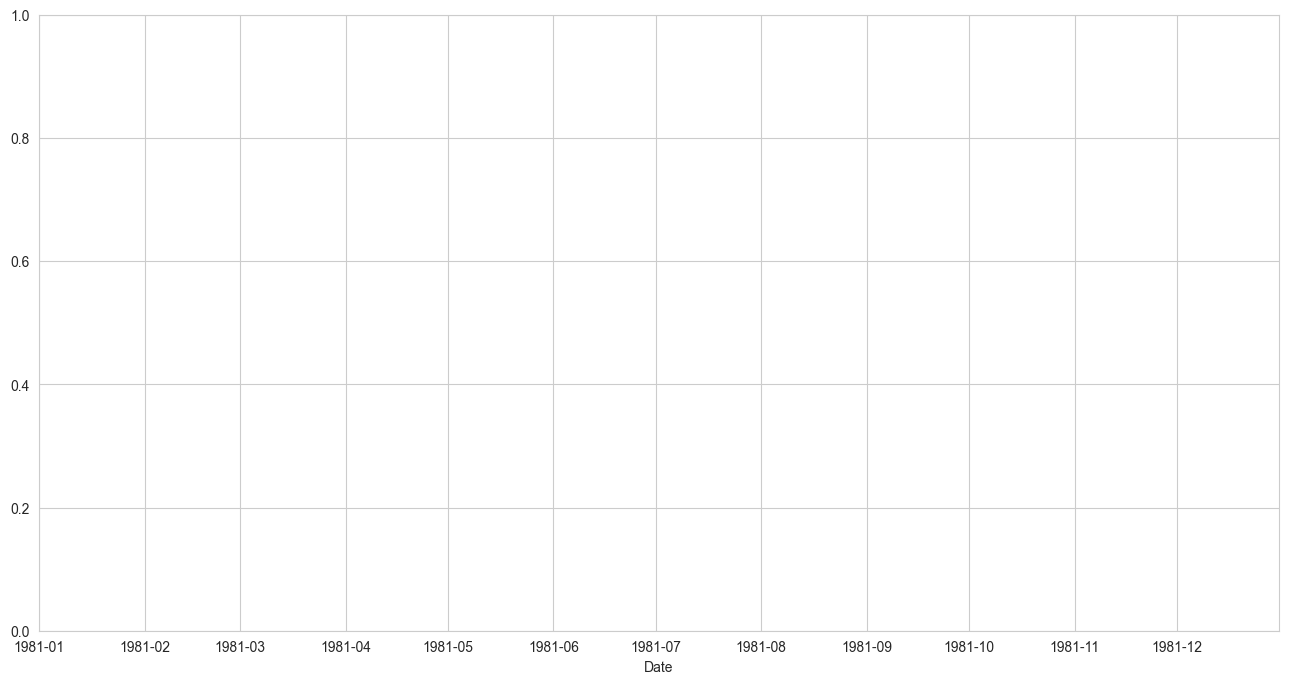

In [26]:
fig, ax1 = plt.subplots(figsize=(16, 8))

year = 1981

ax1.set_xlim([dt.date(year, 1, 1), dt.date(year, 12, 31)])
ax1.set_xlabel('Date')

ax1.xaxis.set_major_locator(mdt.MonthLocator())
ax1.xaxis.set_major_formatter(mdt.DateFormatter('%b'))

ax1.set_ylabel('Precipitation (mm)')
ax1.yaxis.set_major_locator(mtk.MaxNLocator(5))

ax1.grid(c='black', ls='dotted', lw=0.5)

#ax1.plot(rf_9to9_nrfa['Date'], rf_9to9_nrfa['Rain'], 'green', lw=2.5, ls='-', label='nrfa')
#ax1.plot(df_0_1['time'], df_0_1['tp']*100*24, 'orange', lw=2.5, ls='-', label='higher res (0.1°)')
#ax1.plot(df_0_25['time'], df_0_25['tp']*1000*24, 'darkviolet', lw=2.5, ls='-', label='lower res (0.25°)')

ax1.plot(combined_df['Date'], combined_df['Error_0.1'], 'orange', lw=2.5, ls='-', label='error high res (0.1°)')
ax1.plot(combined_df['Date'], combined_df['Error_0.25'], 'darkviolet', lw=2.5, ls='-', label='error lower res (0.25°)')

ax1.legend(loc=0, bbox_to_anchor=(0.25,0.8))

plt.show()

In [27]:
date = (1981,11,11)

data_sep = data_sep.sel(time=dt.datetime(date[0], date[1], date[2]))
data_sep.tp.values

data_low_res = data_low_res.sel(time=dt.datetime(date[0], date[1], date[2]))
data_low_res.tp.values

array([[7.23449874e-05]])

In [28]:
import folium
import geopandas as gpd
import xarray as xr

lat_min = lat_min + 0.1
lon_max = lon_max - 0.1

def plot_with_folium(domain_data, catchment_polygon, date=(1981,1,1), value_column='variable', max_value=0.0025):
    '''
    Plots the spatial data using Folium with intensity based on values.

    Parameters
    ----------
    domain_data : xarray.Dataset
        The dataset containing spatial data.
    lon : float
        Longitude of the point to highlight.
    lat : float
        Latitude of the point to highlight.
    catchment_polygon : shapely.geometry.Polygon, optional
        Polygon representing the catchment area.
    value_column : str, optional
        The name of the column containing the values for intensity.
    '''
    
    points = catchment_polygon.centroid
    lat, lon = osg.BNG_2_latlon(points.x[0],points.y[0])
    
    print(lat, lon)
    
    # Extract data for the requested date
    data = domain_data.sel(time=dt.datetime(date[0], date[1], date[2]))

    # Convert the data to a pandas DataFrame
    df = data.to_dataframe().reset_index()

    # Initialize a Folium map
    m = folium.Map(location=[lat, lon], zoom_start=8)

    # Add the catchment polygon if provided
    gdf = catchment_polygon.to_crs("EPSG:4326")
    layer = folium.GeoJson(gdf, name='catchment').add_to(m)

    # Define a colormap
    colormap = folium.LinearColormap(colors=['blue', 'green', 'yellow', 'orange', 'red'],
                                     vmin=0,
                                     vmax=df[value_column].max())   # df[value_column].max() and min()

    df = df.dropna()

    # Add grid cells to the map
    for _, row in df.iterrows():
        lat = row['latitude']
        lon = row['longitude']
        value = row[value_column]
        color = colormap(value)
        folium.Rectangle(
            bounds=[(lat, lon), (lat-0.1, lon+0.1)],
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.2,
            popup=f"{value_column}: {value}"
        ).add_to(m)
    
    # Add colormap legend
    colormap.caption = value_column
    colormap.add_to(m)

    # Add a layer control
    folium.LayerControl().add_to(m)

    return m

station = 33039
domain_rain = xr.open_dataset(paths.RAINFALL_UK_SHIFTED_HR)
#domain_rain = domain_rain.sortby('latitude', ascending=False)

subset = domain_rain.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

catchment_polygon = gpd.read_file(paths.CATCHMENT_BASINS + '/' + str(station) + '/' + str(str(station) + '.shp'))
max_value = 0.003
plot_with_folium(domain_data=subset, catchment_polygon=catchment_polygon, date=(1981,1,1), value_column='tp', max_value=max_value)

52.048437901694456 -0.7829752013801522


In [31]:
subset.tp.values

array([[[1.07125418e-04, 1.13256029e-04, 1.28662696e-04, ...,
         3.29991165e-04,            nan, 3.45397832e-04],
        [1.01996541e-04, 1.05322297e-04, 1.22932778e-04, ...,
         3.21336185e-04,            nan, 3.27086137e-04],
        [9.34417336e-05, 9.78092932e-05, 1.13356203e-04, ...,
         3.06570628e-04,            nan, 3.14404186e-04],
        ...,
        [1.38519757e-04, 1.94095951e-04, 2.37731477e-04, ...,
         2.70468140e-04,            nan, 2.52717416e-04],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.07986909e-04, 1.46333281e-04, 1.81694486e-04, ...,
         2.05255266e-04,            nan, 1.93875570e-04]],

       [[1.70855726e-04, 1.35153931e-04, 1.24936246e-04, ...,
         7.49497267e-05,            nan, 7.72136452e-05],
        [1.02497408e-04, 1.00373732e-04, 1.12815266e-04, ...,
         6.82982140e-05,            nan, 6.15465278e-05],
        [7.76744428e-05, 

<timed exec>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


1979-01-01T00:00:00.000000000


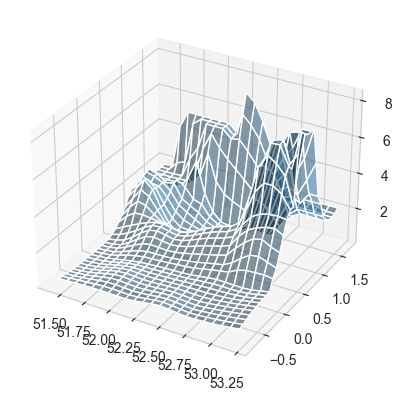

1979-01-02T00:00:00.000000000


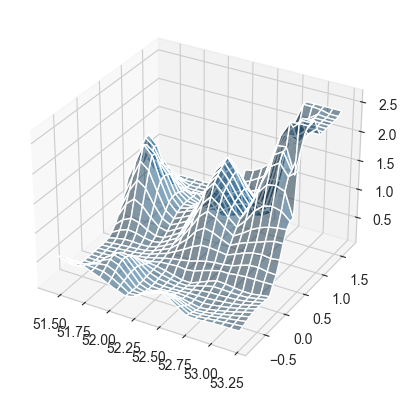

1979-01-03T00:00:00.000000000


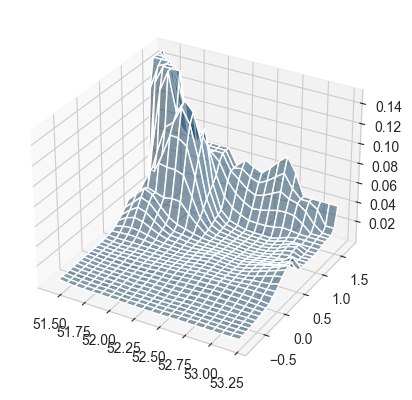

1979-01-04T00:00:00.000000000


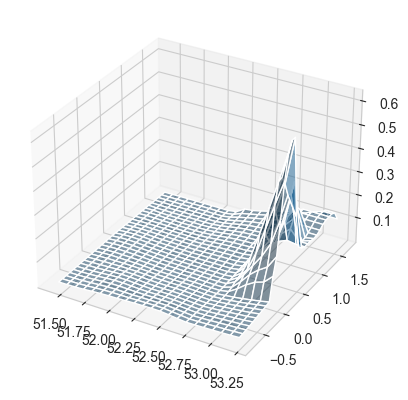

1979-01-05T00:00:00.000000000


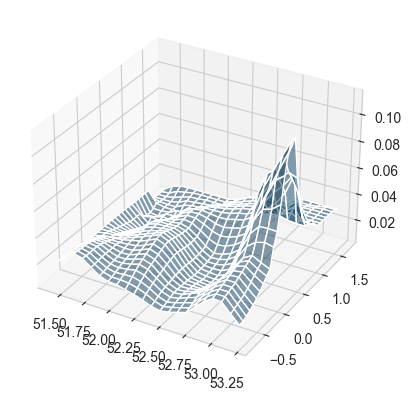

1979-01-06T00:00:00.000000000


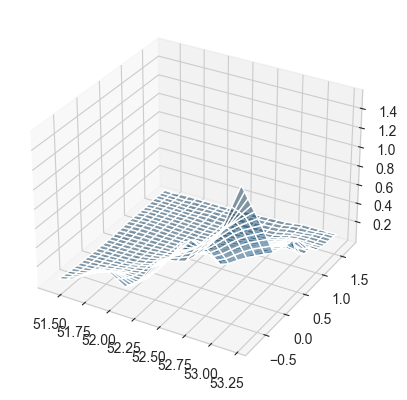

1979-01-07T00:00:00.000000000


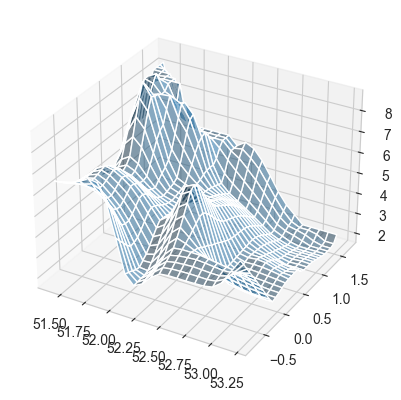

1979-01-08T00:00:00.000000000


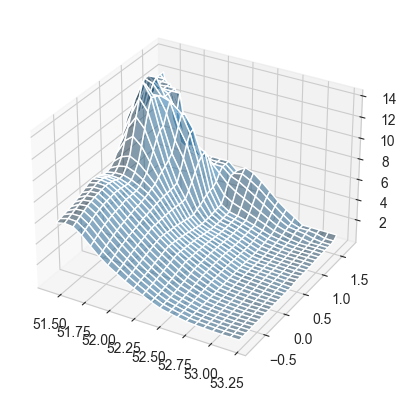

1979-01-09T00:00:00.000000000


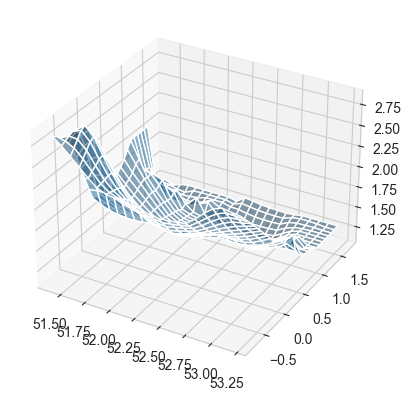

1979-01-10T00:00:00.000000000


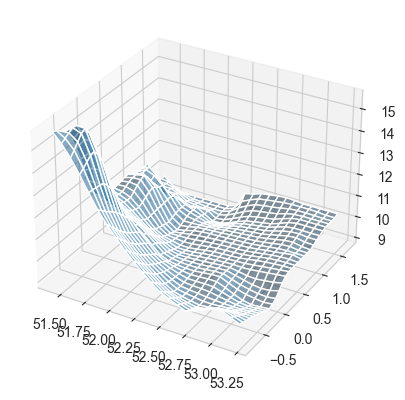

1979-01-11T00:00:00.000000000


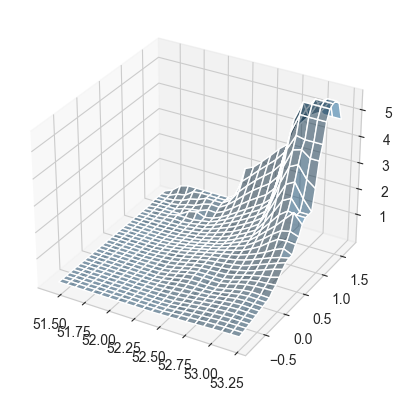

1979-01-12T00:00:00.000000000


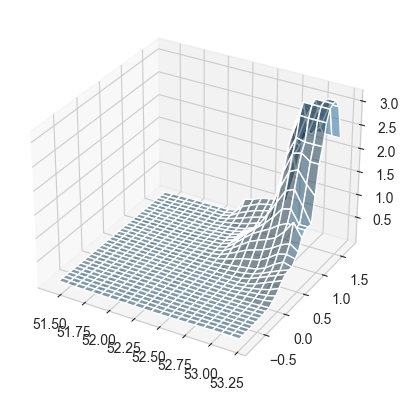

1979-01-13T00:00:00.000000000


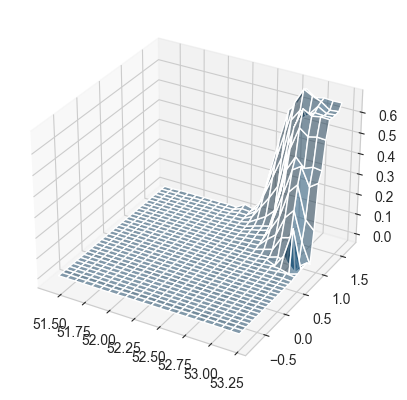

1979-01-14T00:00:00.000000000


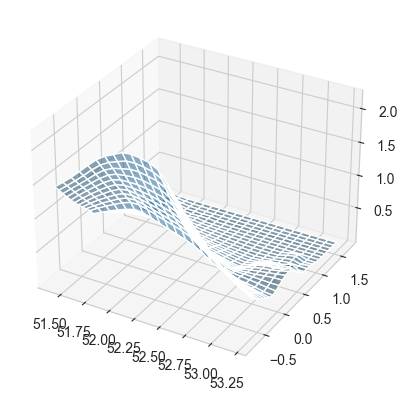

1979-01-15T00:00:00.000000000


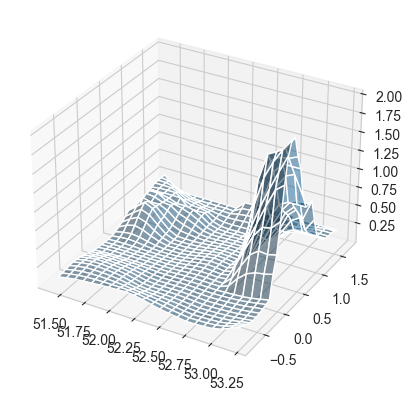

1979-01-16T00:00:00.000000000


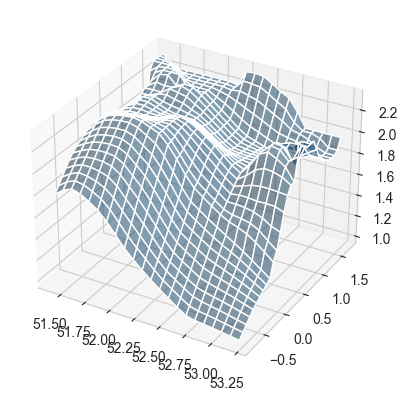

1979-01-17T00:00:00.000000000


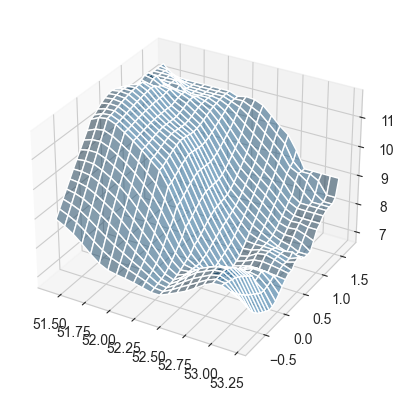

1979-01-18T00:00:00.000000000


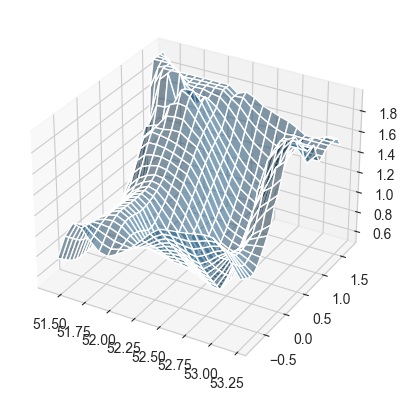

1979-01-19T00:00:00.000000000


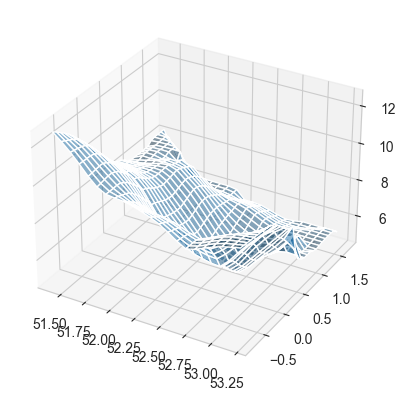

1979-01-20T00:00:00.000000000


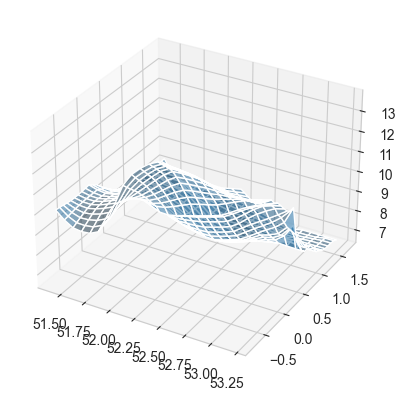

1979-01-21T00:00:00.000000000
1979-01-22T00:00:00.000000000
1979-01-23T00:00:00.000000000
1979-01-24T00:00:00.000000000
1979-01-25T00:00:00.000000000
1979-01-26T00:00:00.000000000
1979-01-27T00:00:00.000000000
1979-01-28T00:00:00.000000000
1979-01-29T00:00:00.000000000
1979-01-30T00:00:00.000000000
1979-01-31T00:00:00.000000000
1979-02-01T00:00:00.000000000
1979-02-02T00:00:00.000000000
1979-02-03T00:00:00.000000000
1979-02-04T00:00:00.000000000
1979-02-05T00:00:00.000000000
1979-02-06T00:00:00.000000000
1979-02-07T00:00:00.000000000
1979-02-08T00:00:00.000000000
1979-02-09T00:00:00.000000000
1979-02-10T00:00:00.000000000
1979-02-11T00:00:00.000000000
1979-02-12T00:00:00.000000000
1979-02-13T00:00:00.000000000
1979-02-14T00:00:00.000000000
1979-02-15T00:00:00.000000000
1979-02-16T00:00:00.000000000
1979-02-17T00:00:00.000000000
1979-02-18T00:00:00.000000000
1979-02-19T00:00:00.000000000
1979-02-20T00:00:00.000000000
1979-02-21T00:00:00.000000000
1979-02-22T00:00:00.000000000
1979-02-23

In [ ]:
%%time
domain_rain = xr.open_dataset(paths.RAINFALL_UK_SHIFTED_HR)
RESOLUTION = 0.1

db = pd.read_csv(paths.DATA + '/Catchments_Database.csv')
for i in [0]: #range(len(db)):
    db_path = paths.CATCHMENT_BASINS + '/' + str(db.loc[i][0])
    boundary_path = db_path + '/' + db.loc[i][4]
    
lat_min, lat_max, lon_min, lon_max = extract_raster_to_interpolate(boundary_path, RESOLUTION)
subset = domain_rain.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

interpolated_functions = interpolate_surface(subset, factor=100*24)

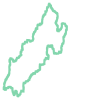

In [16]:
station_nr = 7001
catchment_polygon = gp.read_file(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '.shp'))
converted_polygon = convert_polygon(catchment_polygon.geometry.iloc[0], osg.BNG_2_latlon)
converted_polygon.boundary

In [31]:
%%time
from tqdm import tqdm

rain_columns = (['Rain'] + ['Rain-' + f'{d+1}' for d in range(27)])

rf_test = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_surf_interp.csv'), verbose=False)
rf_test['Date'] = pd.to_datetime(rf_test['Date'])
rf_test = rf_test.drop(columns=rain_columns)

# TODO : replace by selection per dates from 0.1 instead of the manual selection
start = 491+365
rf_test = rf_test[start:start+366+365]

# Compute total rainfall for each time step and store it in the DataFrame
tqdm.pandas()
rf_test['Rain'] = rf_test['Date'].progress_apply(
    lambda time: integrate_rainfall_over_polygon(converted_polygon, interpolated_functions[np.datetime64(time, 'ns')], resolution=0.05)
)
rf_test['Rain'] = rf_test['Rain'].astype('float64')

# Shift the data by 28 days for each day of rain
rf_test = hydropoint.weather_shift(rf_test, 'Rain', 28)

ext = '_9to9'
outpath = paths.CATCHMENT_BASINS + f'/{str(station_nr)}/{str(station_nr)}_lumped{ext}_surf_interp_0.1.csv'
print(outpath)
rf_test.to_csv(outpath, index=True)
rf_test

100%|██████████| 731/731 [01:20<00:00,  9.10it/s]


data/catchment_basins/7001/7001_lumped_9to9_surf_interp_0.1.csv
CPU times: total: 29.2 s
Wall time: 1min 20s


,Unnamed: 0.1,Unnamed: 0,Date,Flow,Temperature,U Windspeed,V Windspeed,Humidity,Snow Melt,Resultant Windspeed,...,Rain-18,Rain-19,Rain-20,Rain-21,Rain-22,Rain-23,Rain-24,Rain-25,Rain-26,Rain-27
856,916,1095,1981-12-31,17.87,279.389330,-0.741191,0.488019,94.507653,1.286859,0.887427,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
857,917,1096,1982-01-01,15.73,277.142841,1.008135,1.654343,92.708291,0.206571,1.937315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
858,918,1097,1982-01-02,15.33,277.089631,-1.317692,0.030851,96.788626,0.947899,1.318053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
859,919,1098,1982-01-03,19.10,275.421616,-4.222723,-1.741287,92.251509,0.179658,4.567655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
860,920,1099,1982-01-04,23.84,274.100319,-3.704785,-1.858049,89.848739,0.000000,4.144608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,1642,1821,1983-12-27,117.20,285.550267,4.984180,4.936141,91.085284,1.880110,7.014808,...,7.153595,2.364678,0.865183,0.149763,1.172750,1.414173,0.528341,0.318200,0.075506,0.913364
1583,1643,1822,1983-12-28,37.81,278.941085,3.897713,1.239975,87.314764,0.161388,4.090196,...,1.174786,7.153595,2.364678,0.865183,0.149763,1.172750,1.414173,0.528341,0.318200,0.075506
1584,1644,1823,1983-12-29,52.00,281.414490,2.908595,3.611304,92.450336,0.184324,4.636964,...,1.242271,1.174786,7.153595,2.364678,0.865183,0.149763,1.172750,1.414173,0.528341,0.318200
1585,1645,1824,1983-12-30,30.88,275.317537,5.181349,0.143545,73.385380,2.291789,5.183337,...,1.671757,1.242271,1.174786,7.153595,2.364678,0.865183,0.149763,1.172750,1.414173,0.528341


In [32]:
rf_test[['Date', 'Rain']]

,Date,Rain
856,1981-12-31,1.782538
857,1982-01-01,0.102611
858,1982-01-02,7.622435
859,1982-01-03,30.004107
860,1982-01-04,24.625681
...,...,...
1582,1983-12-27,34.981403
1583,1983-12-28,10.739482
1584,1983-12-29,6.142053
1585,1983-12-30,11.420211


In [45]:
rf_0_025 = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_surf_interp.csv'), verbose=False)
rf_nrfa = load_data.load_data(paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_nrfa.csv'), verbose=False)
rf_0_025['Date'] = pd.to_datetime(rf_0_025['Date'])
rf_nrfa['Date'] = pd.to_datetime(rf_nrfa['Date'])

# TODO : replace by selection per dates from 0.1 instead of the manual selection
start = 491+365
rf_res_0_25 = rf_0_025[start:start+366+365]
rf_nrfa = rf_nrfa[start:start+366+365]

In [46]:
rf_nrfa

,Unnamed: 0.1,Unnamed: 0,Date,Flow,Temperature,U Windspeed,V Windspeed,Humidity,Snow Melt,Resultant Windspeed,...,Rain-21,Rain-22,Rain-23,Rain-24,Rain-25,Rain-26,Rain-27,Rain_28_Mu,Rain_90_Mu,Rain_180_Mu
856,886,1095,1981-12-31,17.87,279.389330,-0.741191,0.488019,94.507653,1.286859,0.887427,...,0.3,0.1,0.1,0.3,0.7,1.6,0.5,0.717857,4.364444,4.167222
857,887,1096,1982-01-01,15.73,277.142841,1.008135,1.654343,92.708291,0.206571,1.937315,...,1.5,0.3,0.1,0.1,0.3,0.7,1.6,0.700000,3.885556,4.150556
858,888,1097,1982-01-02,15.33,277.089631,-1.317692,0.030851,96.788626,0.947899,1.318053,...,0.3,1.5,0.3,0.1,0.1,0.3,0.7,1.225000,4.001111,4.232778
859,889,1098,1982-01-03,19.10,275.421616,-4.222723,-1.741287,92.251509,0.179658,4.567655,...,3.0,0.3,1.5,0.3,0.1,0.1,0.3,1.664286,4.130000,4.304444
860,890,1099,1982-01-04,23.84,274.100319,-3.704785,-1.858049,89.848739,0.000000,4.144608,...,1.6,3.0,0.3,1.5,0.3,0.1,0.1,1.989286,4.202222,4.355000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,1612,1821,1983-12-27,117.20,285.550267,4.984180,4.936141,91.085284,1.880110,7.014808,...,0.1,2.4,6.2,0.7,1.1,0.4,0.2,4.564286,4.060000,3.539444
1583,1613,1822,1983-12-28,37.81,278.941085,3.897713,1.239975,87.314764,0.161388,4.090196,...,2.0,0.1,2.4,6.2,0.7,1.1,0.4,4.607143,4.027778,3.521667
1584,1614,1823,1983-12-29,52.00,281.414490,2.908595,3.611304,92.450336,0.184324,4.636964,...,3.8,2.0,0.1,2.4,6.2,0.7,1.1,5.407143,4.274444,3.621667
1585,1615,1824,1983-12-30,30.88,275.317537,5.181349,0.143545,73.385380,2.291789,5.183337,...,1.6,3.8,2.0,0.1,2.4,6.2,0.7,6.057143,4.405556,3.726667


In [47]:
compare = rf_res_0_25[['Date', 'Rain']].merge(rf_test[['Date', 'Rain']], on='Date')
compare = compare.rename(columns={'Rain_x': 'Rain_0.25', 'Rain_y':'Rain_0.1'})
compare = rf_nrfa[['Date', 'Rain']].merge(compare, on='Date')
compare

,Date,Rain,Rain_0.25,Rain_0.1
0,1981-12-31,0.2,0.785311,1.782538
1,1982-01-01,0.0,0.062108,0.102611
2,1982-01-02,16.3,6.440175,7.622435
3,1982-01-03,13.0,18.513571,30.004107
4,1982-01-04,9.4,17.610510,24.625681
...,...,...,...,...
726,1983-12-27,32.3,28.278568,34.981403
727,1983-12-28,1.4,7.588363,10.739482
728,1983-12-29,22.8,7.699348,6.142053
729,1983-12-30,19.3,8.385086,11.420211


In [57]:
import matplotlib.dates as mdt
import matplotlib.ticker as mtk

def year_plot(maxflow, df, y_pred, y_obsv, year, colour1='orangered',
              colour2='Teal', extra=None, colour3='cadetblue'):

    fig, ax = plt.subplots(figsize=(16, 8))
    if extra is not None:
         ax.plot(df['Date'], df[extra], colour3, lw=2.5)
    ax.plot(df['Date'], df[y_pred], colour1, lw=2.5)
    ax.plot(df['Date'], df[y_obsv], colour2, lw=2.5)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Flow (m'+r'$^3$'+'s'+r'$^{-1}$'+')')
    ax.set_xlim([dt.date(year, 1, 1), dt.date(year, 12, 31)])
    ax.set_ylim(0,maxflow)
    ax.xaxis.set_major_locator(mdt.MonthLocator())
    ax.xaxis.set_major_formatter(mdt.DateFormatter('%b'))
    ax.yaxis.set_major_locator(mtk.MaxNLocator(5))
    ax.legend(['Higher Res', 'Lower Res'], loc='upper left')
    ax.grid(c='black', ls='dotted', lw=0.5)
    plt.show()


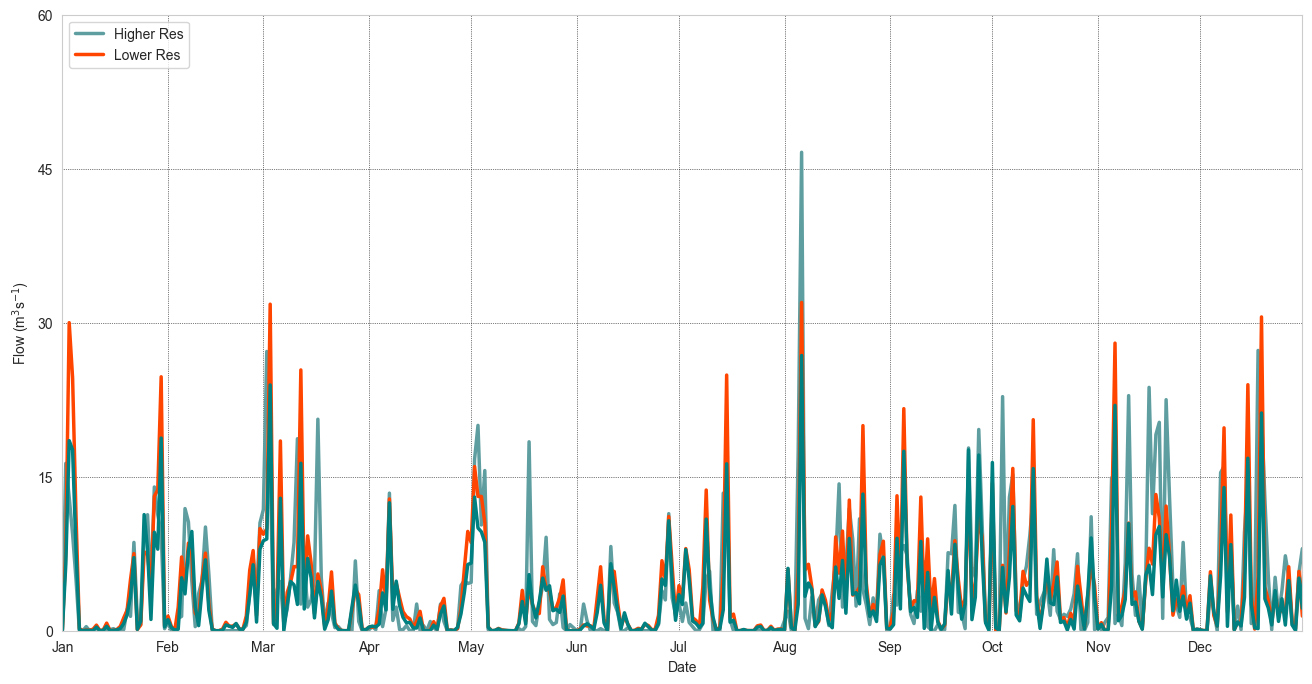

In [58]:
year_plot(60, compare, 'Rain_0.1', 'Rain_0.25', 1982, extra='Rain')  